In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from utils import*

In [4]:
# General settings
import matplotlib as mpl
mpl.rc_file('/Users/ulyanadupletsa/Documents/PhDThesisPlots/matplotlibrc')

mpl.rc('xtick', labelsize = 16) 
mpl.rc('ytick', labelsize = 16)

In [5]:
my_palette_blue = ['#97a7a7', '#2f4f4f']
my_palette_orange = ['#f8c997', '#f6b26b']

In [6]:
PATH_TO_RESULTS = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/'
PATH_TO_PLOTS = '/Users/ulyanadupletsa/Documents/PhDThesisPlots/plots/chapter3/'
PATH_TO_POSTERIORS_AVERAGED = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples_averaged/'
PATH_TO_POSTERIORS_m1m2 = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples_averaged_uniform_in_m12_prior/'
PATH_TO_INFO = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/info/'
PATH_TO_LVK_SAMPLES = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples/lvk_samples/'
PATH_TO_FISHER_SAMPLES = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples_averaged/'
PATH_TO_FISHER_PLUS_PRIORS_SAMPLES = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples_averaged_uniform_in_m12_prior/'
PATH_TO_GWFISH_AVERAGED = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/gwfish_averaged/'

In [7]:
waveform = 'IMRPhenomXPHM'
events = np.loadtxt(PATH_TO_INFO + 'events_wf_median_priors_%s.txt' %waveform, dtype=str)
with open(PATH_TO_INFO + 'detectors_dictionary.pkl', 'rb') as f:
    detectors = pickle.load(f)
# order events in the events list by date referring to the number in labels.append(event.split('-')[3][0:8])
events_tag = []
for event in events:
    events_tag.append(event.split('-')[3][0:8])

naming_df = pd.DataFrame({'event': events, 'tag': events_tag})
naming_df = naming_df.sort_values(by='tag')
ordered_events = naming_df['event'].values
params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 
            'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
confidence_level = 90 # number between 0 and 100

In [8]:
cl90_lvk = {}
for event in ordered_events:
    samples_lvk = pd.read_hdf(PATH_TO_LVK_SAMPLES + 'lvk_samples_%s.hdf5' %(event))
    cl90_lvk[event] = get_confidence_interval(samples_lvk, params, confidence_level)

cl90_fisher = {}
cl90_fisher_plus_priors = {}

for event in ordered_events:
    cl90_fisher_one_ev = {}
    cl90_fisher_plus_priors_one_ev = {}

    for i in range(30):
        samples_fisher = pd.read_hdf(PATH_TO_POSTERIORS_AVERAGED + 'fisher_samples/fisher_samples_%s_%s.hdf5' %(event, i))
        cl90_fisher_one_ev[i] = get_confidence_interval(samples_fisher, params, confidence_level)

        samples_fisher_plus_priors = pd.read_hdf(PATH_TO_POSTERIORS_m1m2 + 'fisher_plus_priors_samples/fisher_plus_priors_samples_%s_%s.hdf5' %(event, i))
        cl90_fisher_plus_priors_one_ev[i] = get_confidence_interval(samples_fisher_plus_priors, params, confidence_level)

    cl90_fisher[event] = cl90_fisher_one_ev
    cl90_fisher_plus_priors[event] = cl90_fisher_plus_priors_one_ev

In [9]:
range_summary = {key: [] for key in params}

for param in params:
    range_summary[param] = {key: [] for key in ['gwfish', 'gwfish_plus_priors']}
    for event in ordered_events:
        levels_gwfish = []
        levels_gwfish_plus_priors = []
        for i in range(30):
            levels_gwfish.append((cl90_fisher[event][i][param][1] - cl90_fisher[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
            levels_gwfish_plus_priors.append((cl90_fisher_plus_priors[event][i][param][1] - cl90_fisher_plus_priors[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
        range_summary[param]['gwfish'].append(levels_gwfish)
        range_summary[param]['gwfish_plus_priors'].append(levels_gwfish_plus_priors)

In [10]:
num_detectors = {}
for event in ordered_events:
    num_detectors[event] = len(detectors[event])

In [11]:
lbs_errs = ['snr', 'chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn',
        'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
        'network_optimal_snr',
        'err_chirp_mass', 'err_mass_ratio', 'err_luminosity_distance', 'err_dec', 'err_ra',
        'err_theta_jn', 'err_psi', 'err_phase', 'err_geocent_time', 'err_a_1', 'err_a_2', 'err_tilt_1',
        'err_tilt_2', 'err_phi_12', 'err_phi_jl', 'err_sky_location']

param_label = {'chirp_mass': r'$\mathcal{M}_c$', 'mass_ratio': r'$q$', 'luminosity_distance': r'$d_L$',
                'dec': r'$\texttt{DEC}$', 'ra': r'$\texttt{RA}$', 'theta_jn': r'$\theta_{JN}$', 'psi': r'$\Psi$',
                'phase': r'$\phi$', 'geocent_time': r'$t_c$', 'a_1': r'$a_1$', 'a_2': r'$a_2$',
                'tilt_1': r'$\texttt{tilt}_1$', 'tilt_2': r'$\texttt{tilt}_2$', 'phi_12': r'$\texttt{phi}_{12}$',
                'phi_jl': r'$\texttt{phi}_{JL}$'}

In [12]:
median_summary = {key: [] for key in params}

for param in params:
    median_summary[param] = {key: [] for key in ['gwfish', 'gwfish_plus_priors']}
    for event in ordered_events:
        levels_gwfish = []
        levels_gwfish_plus_priors = []
        for i in range(30):
            levels_gwfish.append((cl90_fisher[event][i][param][1] - cl90_fisher[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
            levels_gwfish_plus_priors.append((cl90_fisher_plus_priors[event][i][param][1] - cl90_fisher_plus_priors[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
        median_summary[param]['gwfish'].append(np.median(levels_gwfish))
        median_summary[param]['gwfish_plus_priors'].append(np.median(levels_gwfish_plus_priors))

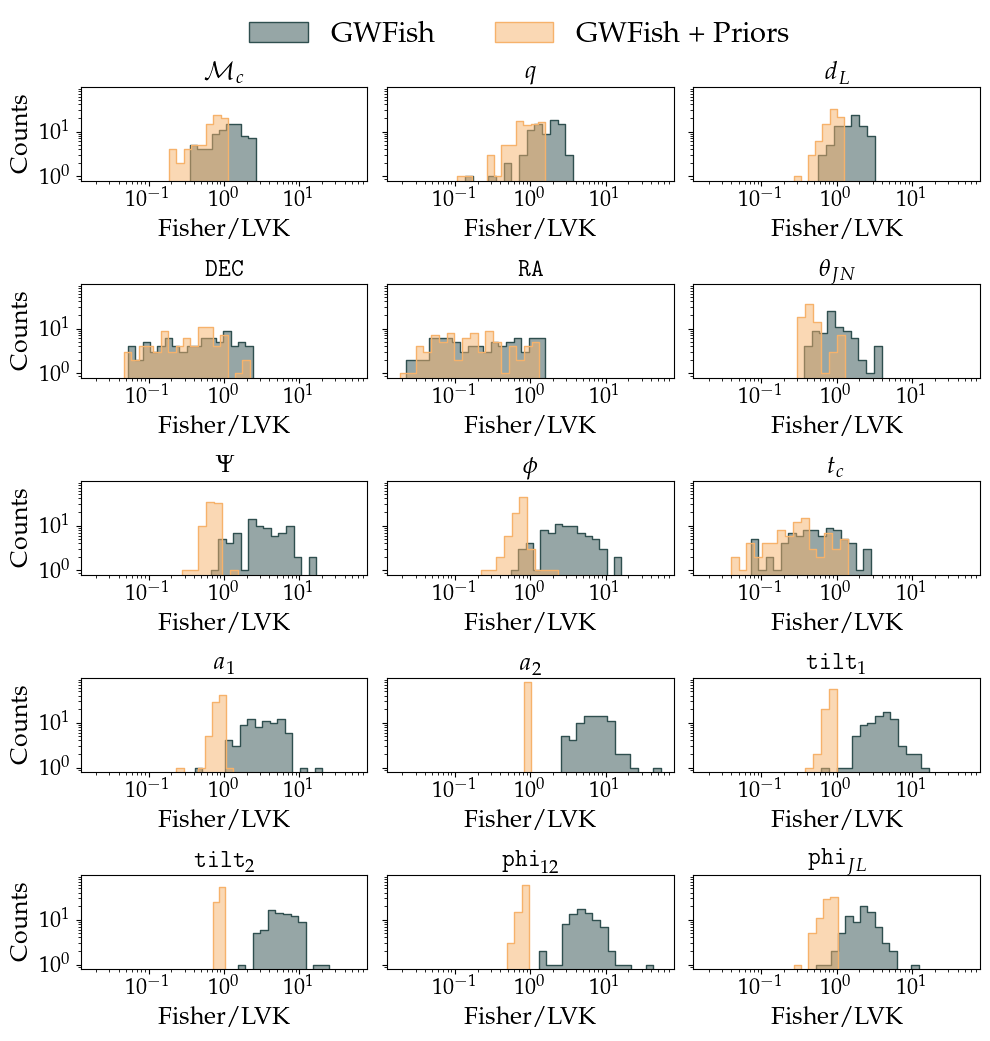

In [13]:
# plot histograms of the median values
fig, axs = plt.subplots(5, 3, figsize=(10, 10), sharex=False, sharey=True)
set_fontsize = 18

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.histplot(median_summary[param]['gwfish'], log_scale=True, binwidth=0.1, element='step', ax=ax, label='GWFish', alpha = 0.5, color = my_palette_blue[1])
    ax = sns.histplot(median_summary[param]['gwfish_plus_priors'], log_scale=True, binwidth=0.1, element='step', ax=ax, label='GWFish + Priors', alpha=0.5, color = my_palette_orange[1])
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.set_xlabel('Fisher/LVK', fontsize=set_fontsize)
    ax.set_ylabel('Counts', fontsize=set_fontsize)
    ax.set_xlim(10**(-1.9), 10**(1.9))
    ax.set_title('%s' %param_label[param], fontsize=set_fontsize, weight='bold')


fig.legend(['GWFish', 'GWFish + Priors'],
            fontsize=21, bbox_to_anchor=(0.525, 1.01), loc='center', 
            ncol = 2, frameon=False)    
plt.subplots_adjust(wspace=0.01, 
                    hspace=0.2)
plt.tight_layout()
plt.savefig('plots/summary_plot_averaged_median.pdf', bbox_inches='tight')

plt.show()